In [408]:
with open('libraries.py') as f:
    code = f.read()
exec(code)

In [409]:
pd.reset_option('all')
pd.set_option('display.max_rows', 100)

In [410]:
# determine user
user = getpass.getuser()
if user == 'peymansh':
    main_folder_path = '/Users/peymansh/Dropbox (MIT)/Research/AI and Occupations/ai-exposure'
    data_path = f'{main_folder_path}/output'

In [411]:
# Pick occupation
def pick_occupation(occupation):
    if occupation == 'travelAgents':
        GPT_input_occupation = 'travel agents'
        plot_title_occupation = 'Travel Agents'
        occupation_code = '41-3041'
    elif occupation == 'insuranceUnderwriters':
        GPT_input_occupation = 'insurance underwriters'
        plot_title_occupation = 'Insurance Underwriters'
        occupation_code = '13-2053'
    elif occupation == 'pileDriverOperators':
        GPT_input_occupation = 'pile dirver operators'
        plot_title_occupation = 'Pile Driver Operators'
        occupation_code = '47-2072'
    elif occupation == 'dredgeOperators':
        GPT_input_occupation = 'dredge operators'
        plot_title_occupation = 'Dredge Operators'
        occupation_code = '53-7031'
    elif occupation == 'gradersAndSortersForAgriculturalProducts':
        GPT_input_occupation = 'Graders and sorters for agricultural products'
        plot_title_occupation = 'Graders and Sorters for Agricultural Products'
        occupation_code = '45-2041'
    elif occupation == 'reinforcingIronAndRebarWorkers':
        GPT_input_occupation = 'Reinforcing iron and rebar working'
        plot_title_occupation = 'Reinforcing Iron and Rebar Workers'
        occupation_code = '47-2171'
    elif occupation == 'insuranceAppraisersForAutoDamage':
        GPT_input_occupation = 'Insurance appraisers for auto damage'
        plot_title_occupation = 'Insurance Appraisers, Auto Damage'
        occupation_code = '13-1032'
    elif occupation == 'floorSandersAndFinishers':
        GPT_input_occupation = 'Floor sanders and finishers'
        plot_title_occupation = 'Floor Sanders and Finishers'
        occupation_code = '47-2043'
    elif occupation == 'dataEntryKeyer':
        GPT_input_occupation = 'Data entry keyers'
        plot_title_occupation = 'Data Entry Keyers'
        occupation_code = '43-9021'
    elif occupation == 'athletesAndSportsCompetitors':
        GPT_input_occupation = 'Athletes and sports competitors'
        plot_title_occupation = 'Athletes and Sports Competitors'
        occupation_code = '27-2021'
    elif occupation == 'audiovisualEquipmentInstallerAndRepairers':
        GPT_input_occupation = 'Audiovisual equipment installer and repairers'
        plot_title_occupation = 'Audiovisual Equipment Installers and Repairers'
        occupation_code = '49-2097'
    elif occupation == 'hearingAidSpecialists':
        GPT_input_occupation = 'Hearing aid specialists'
        plot_title_occupation = 'Hearing Aid Specialists'
        occupation_code = '29-2092'
    elif occupation == 'personalCareAides':
        GPT_input_occupation = 'Personal care aides'
        plot_title_occupation = 'Personal Care Aides'
        occupation_code = '31-1122'
    elif occupation == 'proofreadersAndCopyMarkers':
        GPT_input_occupation = 'Proofreaders and copy markers'
        plot_title_occupation = 'Proofreaders and Copy Markers'
        occupation_code = '43-9081'
    elif occupation == 'chiropractors':
        GPT_input_occupation = 'Chiropractors'
        plot_title_occupation = 'Chiropractors'
        occupation_code = '29-1011'
    elif occupation == 'shippingReceivingAndInventoryClerks':
        GPT_input_occupation = 'Shipping, receiving, and inventory clerks'
        plot_title_occupation = 'Shipping, Receiving, and Inventory Clerks'
        occupation_code = '43-5071'
    elif occupation == 'cooksShortOrder':
        GPT_input_occupation = 'Cooks, short order'
        plot_title_occupation = 'Cooks, Short Order'
        occupation_code = '35-2015'
    elif occupation == 'orthodontists':
        GPT_input_occupation = 'Orthodontists'
        plot_title_occupation = 'Orthodontists'
        occupation_code = '29-1023'
    elif occupation == 'subwayAndStreetcarOperators':
        GPT_input_occupation = 'Subway and streetcar operators'
        plot_title_occupation = 'Subway and Streetcar Operators'
        occupation_code = '53-4041'
    elif occupation == 'packersAndPackagersHand':
        GPT_input_occupation = 'Packers and packagers (with hand)'
        plot_title_occupation = 'Packers and Packagers, Hand'
        occupation_code = '53-7064'
    elif occupation == 'hoistAndWinchOperators':
        GPT_input_occupation = 'Hoist and winch operators'
        plot_title_occupation = 'Hoist and Winch Operators'
        occupation_code = '53-7041'
    elif occupation == 'forgingMachineSettersOperatorsAndTenders':
        GPT_input_occupation = 'Forging machine setters, operators, and tenders, metal and plastic'
        plot_title_occupation = 'Forging Machine Setters, Operators, and Tenders, Metal and Plastic'
        occupation_code = '51-4022'
    elif occupation == 'avionicsTechnicians':
        GPT_input_occupation = 'Avionics technicians'
        plot_title_occupation = 'Avionics Technicians'
        occupation_code = '49-2091'
    elif occupation == 'dishwashers':
        GPT_input_occupation = 'Dishwashers'
        plot_title_occupation = 'Dishwashers'
        occupation_code = '35-9021'
    elif occupation == 'dispatchersExceptPoliceFireAndAmbulance':
        GPT_input_occupation = 'Dispatchers, except police, fire, and ambulance'
        plot_title_occupation = 'Dispatchers, Except Police, Fire, and Ambulance'
        occupation_code = '43-5032'
    elif occupation == 'familyMedicinePhysicians':
        GPT_input_occupation = 'Family medicine physicians'
        plot_title_occupation = 'Family Medicine Physicians'
        occupation_code = '29-1215'
    elif occupation == 'MachineFeedersAndOffbearers':
        GPT_input_occupation = 'Machine feeders and offbearers'
        plot_title_occupation = 'Machine Feeders and Offbearers'
        occupation_code = '53-7063'
    elif occupation == 'shampooers':
        GPT_input_occupation = 'shampooers'
        plot_title_occupation = 'Shampooers'
        occupation_code = '39-5093'
    
    occupation_folder = f'{data_path}/daily_tasks_occupations_analysis/{occupation}'

    # create folder in directory if it doesn't exist
    if not os.path.exists(occupation_folder):
        os.makedirs(occupation_folder)

    return GPT_input_occupation, plot_title_occupation, occupation_code, occupation_folder

In [412]:
onet_data_path = f'{data_path}/data/onet_occupations_yearly.csv'

# list of occupations to create DAGs for
occupation_list = ['travelAgents', 'insuranceUnderwriters', 'pileDriverOperators', 
                   'dredgeOperators', 'gradersAndSortersForAgriculturalProducts', 'reinforcingIronAndRebarWorkers',
                   'insuranceAppraisersForAutoDamage', 'floorSandersAndFinishers', 'dataEntryKeyer', 
                   'athletesAndSportsCompetitors', 'audiovisualEquipmentInstallerAndRepairers', 'hearingAidSpecialists', 
                   'personalCareAides', 'proofreadersAndCopyMarkers', 'chiropractors', 
                   'shippingReceivingAndInventoryClerks', 'cooksShortOrder', 'orthodontists',
                   'subwayAndStreetcarOperators', 'packersAndPackagersHand', 'hoistAndWinchOperators', 
                   'forgingMachineSettersOperatorsAndTenders', 'avionicsTechnicians', 'dishwashers', 
                   'dispatchersExceptPoliceFireAndAmbulance', 'familyMedicinePhysicians', 'MachineFeedersAndOffbearers'
                   ]

occupation = 'travelAgents'
#occupation = 'insuranceUnderwriters'
#occupation = 'pileDriverOperators'

# Generate occupation-specific strings
GPT_input_occupation, plot_title_occupation, occupation_code, occupation_folder = pick_occupation(occupation)

In [413]:
# set alpha as AI quality metric
epsilon = 1e-8
alpha_list = [epsilon, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1-epsilon]

### Initialize input-output paths

In [414]:
# Manual DAG
input_path = f'{occupation_folder}/{occupation}_M_DAG_df.csv'
output_path = f'{occupation_folder}/{occupation}_costMin_M.csv'

# First Last Task DAG
input_path = f'{occupation_folder}/{occupation}_FLT_GPT_DAG_df.csv'
output_path = f'{occupation_folder}/{occupation}_costMin_FLT.csv'

# # Conditioned First Last Task DAG
# input_path = f'{occupation_folder}/{occupation}_CFLT_GPT_DAG_df.csv'
# output_path = f'{occupation_folder}/{occupation}_costMin_CFLT.csv'

# # Partitioned DAG
# input_path = f'{occupation_folder}/{occupation}_P_GPT_DAG_df.csv'
# output_path = f'{occupation_folder}/{occupation}_costMin_P.csv'

# # Conditioned Partitioned DAG
# input_path = f'{occupation_folder}/{occupation}_CP_GPT_DAG_df.csv'
# output_path = f'{occupation_folder}/{occupation}_costMin_CP.csv'

In [415]:
# read DAG
dag_df = pd.read_csv(input_path)

# remove edges if comment column labeled with "TriangleRemovedFlag" (edge is there for plotting purposes and is not part of the actual DAG)
if 'comment' in dag_df.columns:
    dag_df = dag_df[~dag_df['comment'].str.endswith('TriangleRemovedFlag')]

# get task stats
tasks_stats = pd.read_csv(f'{occupation_folder}/{occupation}_taskStats.csv')
tasks_stats

# print stats
#tasks_stats.iloc[:,1:].sum()
dag_df

,source,target,comment
0,Converse with customer to determine destinatio...,Collect payment for transportation and accommo...,The worker collecting payment needs to know th...
1,"Compute cost of travel and accommodations, usi...",Collect payment for transportation and accommo...,The worker collecting payment needs to know th...
2,"Book transportation and hotel reservations, us...",Collect payment for transportation and accommo...,The worker collecting payment needs to know th...
3,"Plan, describe, arrange, and sell itinerary to...",Collect payment for transportation and accommo...,The worker collecting payment needs to know th...
4,Collect payment for transportation and accommo...,Print or request transportation carrier ticket...,The worker printing or requesting transportati...
5,Collect payment for transportation and accommo...,"Record and maintain information on clients, ve...",The worker recording and maintaining informati...
6,Converse with customer to determine destinatio...,"Compute cost of travel and accommodations, usi...",The worker computing the cost of travel and ac...
7,Converse with customer to determine destinatio...,"Book transportation and hotel reservations, us...",The worker booking transportation and hotel re...
8,Converse with customer to determine destinatio...,"Plan, describe, arrange, and sell itinerary to...","The worker planning, describing, arranging, an..."
9,Converse with customer to determine destinatio...,Provide customer with brochures and publicatio...,The worker providing brochures and travel info...


In [416]:
# extract list of tasks and create a dictionary for indexing tasks
tasks_list = tasks_stats['task'].unique()
tasks_dict = {i: node for i, node in enumerate(tasks_list, start=0)}

# create numpy array of adjacency matrix
adjacency_matrix = np.zeros((len(tasks_list), len(tasks_list)), dtype=int)
aux_dict = {value: key for key, value in tasks_dict.items()}
for _, row in dag_df.iterrows():
    source_index = aux_dict[row['source']]
    target_index = aux_dict[row['target']]
    adjacency_matrix[source_index, target_index] = 1

tasks_dict

{0: 'Collect payment for transportation and accommodations from customer.',
 1: 'Converse with customer to determine destination, mode of transportation, travel dates, financial considerations, and accommodations required.',
 2: 'Compute cost of travel and accommodations, using calculator, computer, carrier tariff books, and hotel rate books, or quote package tours costs.',
 3: 'Book transportation and hotel reservations, using computer or telephone.',
 4: 'Plan, describe, arrange, and sell itinerary tour packages and promotional travel incentives offered by various travel carriers.',
 5: 'Provide customer with brochures and publications containing travel information, such as local customs, points of interest, or foreign country regulations.',
 6: 'Print or request transportation carrier tickets, using computer printer system or system link to travel carrier.',
 7: 'Record and maintain information on clients, vendors, and travel packages.',
 8: '"Target"'}

In [417]:
# Define a break-even difficulty for base AI quality (alpha)
# Above break-even difficulty threshold task is done manually
# As AI quality (alpha) goes up break-even difficulty goes up
for index, alpha in enumerate(alpha_list):
    if index % np.floor(n/4) == np.floor(n/4) - 1:
        pretty_label = str(np.round(alpha,2)*100).split('.')[0]
        #tasks_stats[f'be_difficulty_{pretty_label}'] = np.log(tasks_stats['management_cost'] / tasks_stats['human_cost']) / np.log(alpha)


# add task_dict key and reset index
aux_dict = {value: key for key, value in tasks_dict.items()}
tasks_stats['dict_index'] = tasks_stats.apply(lambda row: aux_dict[row.task], axis=1)
tasks_stats = tasks_stats.sort_values(by='dict_index')
tasks_stats = tasks_stats.set_index('dict_index', drop=False)
tasks_stats.index.name = None

In [418]:
# create dictionaries for human cost, management cost, and difficulty
M_dict = dict(zip(tasks_stats['dict_index'], tasks_stats['human_cost']))
A_dict = dict(zip(tasks_stats['dict_index'], tasks_stats['management_cost']))
D_dict = dict(zip(tasks_stats['dict_index'], tasks_stats['difficulty']))

### Generate all possible partition schemes for the set of tasks (ignoring structre of the DAG)

In [419]:
from itertools import combinations

def partitions(set_):
    if not set_:
        yield []
        return
    for i in range(1, len(set_) + 1):
        for part in combinations(set_, i):
            remaining = set(set_) - set(part)
            if not remaining:
                yield [list(part)]
            else:
                for b in partitions(list(remaining)):
                    yield [list(part)] + b

def generate_unique_partitions(numbers):
    all_partitions = set()
    for partition in partitions(numbers):
        # Create a frozenset of frozensets to make each partition hashable and order-independent
        partition_set = frozenset(frozenset(part) for part in partition)
        all_partitions.add(partition_set)
    
    # Convert the frozensets back to lists for the final output
    unique_partitions = [list(map(list, partition)) for partition in all_partitions]

    # Sort elements
    unique_partitions = sorted([sorted(x) for x in unique_partitions], key=len)
    return unique_partitions

In [420]:
# Generate list of numbers for non-"Target" tasks in occupation
tasks_list_numbers = list(range(len(tasks_list)-1)) # -1 for "Target" task: don't want to include it in task partitions as it's its own separate partition

# Generate all possible partitioning schemes
all_partitions = generate_unique_partitions(tasks_list_numbers)


### Check if partition scheme is "valid" (i.e., if its non-singleton partitions are a connected graph)

In [421]:
def is_connected(matrix):
    # Number of nodes in the matrix
    num_nodes = matrix.shape[0]
    
    # Visited array to keep track of visited nodes
    visited = np.zeros(num_nodes, dtype=bool)
    
    # Helper function to perform DFS
    def dfs(node):
        visited[node] = True
        # Visit all the neighbors of the current node
        for neighbor in range(num_nodes):
            if matrix[node, neighbor] == 1 and not visited[neighbor]:
                dfs(neighbor)
            elif matrix[neighbor, node] == 1 and not visited[neighbor]:
                dfs(neighbor)
    
    # Start DFS from the first node (node 0)
    dfs(0)
    
    # If all nodes are visited, the matrix is connected
    return np.all(visited)


def validate_partition_using_connectedness(adjacency_matrix, tasks_list):
    # Return valid if Singleton
    if len(tasks_list) == 1:
        return True
    # Check if partition forms connected graph
    else:
        # Subset original adjacency matrix
        subset_matrix = adjacency_matrix[np.ix_(tasks_list, tasks_list)]

        # check if subset matrix is a connected graph
        subset_matrix_connected = is_connected(subset_matrix)

        # return true if connected and false otherwise
        return subset_matrix_connected

In [422]:
# Get valid partitioning schemes from all possible partitions to cut computation load
valid_partitions = []
for scheme in all_partitions:
    # Set valid partitions count to 0
    valid_partition_count = 0
    for partition in scheme:
        valid_partition = validate_partition_using_connectedness(adjacency_matrix, partition)
        if valid_partition:
            valid_partition_count += 1
    
    # If number of valid partitions within a partition scheme is equal to 
    # number of partitions in partition scheme then partition scheme is valid
    if valid_partition_count == len(scheme):
        valid_partitions.append(scheme)

# Print stats
print(f'Number of all possible partitioning schemes: {len(all_partitions)}')
print(f'Number of valid partitioning schemes given DAG structure: {len(valid_partitions)}')

# print some partitions
print('\nExample partitions:')
for partition in valid_partitions[10:20]:
    print(partition)

Number of all possible partitioning schemes: 4140
Number of valid partitioning schemes given DAG structure: 1754

Example partitions:
[[0, 1, 5, 6, 7], [2, 3, 4]]
[[0, 1, 3, 5, 6], [2, 4, 7]]
[[0, 1, 2, 3, 4, 5, 6], [7]]
[[0, 2, 3, 4, 7], [1, 5, 6]]
[[0, 1, 2, 3, 5], [4, 6, 7]]
[[0, 3, 6, 7], [1, 2, 4, 5]]
[[0, 1, 2, 3, 5, 7], [4, 6]]
[[0, 1, 4, 5, 6], [2, 3, 7]]
[[0, 3, 6], [1, 2, 4, 5, 7]]
[[0, 1, 3, 4, 5, 6, 7], [2]]


In [423]:
# get how many "singleton" partitions there are in valid partition
valid_execution_plans = pd.DataFrame()
for my_valid_partition in valid_partitions:
    singleton_partitions = [lst[0] for lst in my_valid_partition if len(lst) == 1]
    #singleton_partitions = [lst for lst in my_valid_partition if len(lst) == 1]

    # get the power set of "singleton" partitions
    # goal is to generate ways singleton tasks can be done by human or AI
    all_combinations = [[]]
    for r in range(1, len(singleton_partitions) + 1):
        combinations_r = itertools.combinations(singleton_partitions, r)
        all_combinations.extend(combinations_r)

    # Convert the combinations to a list of lists (optional)
    all_combinations = [list(comb) for comb in all_combinations]
    all_combinations

    # repeat my_valid_partition for each combination in all_combinations to create a dataframe later
    my_valid_partition_repeated = [my_valid_partition for _ in range(len(all_combinations))]
    aux_df = pd.DataFrame({'execution_plan': my_valid_partition_repeated, 
                        'human_tasks': all_combinations})
    
    # append to valid_execution_plans
    valid_execution_plans = pd.concat([valid_execution_plans, aux_df], ignore_index=True)

valid_execution_plans

,execution_plan,human_tasks
0,"[[0, 1, 2, 3, 4, 5, 6, 7]]",[]
1,"[[0, 3, 4, 6], [1, 2, 5, 7]]",[]
2,"[[0, 1, 2, 3, 5, 6], [4, 7]]",[]
3,"[[0, 1, 2, 4, 5, 6], [3, 7]]",[]
4,"[[0, 1, 2, 4, 5, 6, 7], [3]]",[]
...,...,...
11538,"[[0], [1], [2], [3], [4], [5], [6], [7]]","[0, 1, 2, 4, 5, 6, 7]"
11539,"[[0], [1], [2], [3], [4], [5], [6], [7]]","[0, 1, 3, 4, 5, 6, 7]"
11540,"[[0], [1], [2], [3], [4], [5], [6], [7]]","[0, 2, 3, 4, 5, 6, 7]"
11541,"[[0], [1], [2], [3], [4], [5], [6], [7]]","[1, 2, 3, 4, 5, 6, 7]"


In [424]:
def get_partition_boundary(adjacency_matrix, partition):
    # create a matrix whose columns are nodes not in the partition and whose rows are nodes in the partition
    # (subset adjacency matrix to outgoing edges of partition nodes --i.e., rows-- and incoming edges of non-partition nodes --i.e., columns.)
    reduced_matrix = np.delete(adjacency_matrix, partition, axis=1) 
    reduced_matrix = reduced_matrix[partition, :]

    # find nodes in partition w/ an edge to non-partition nodes
    partition_boundary_tasks = [i for i in partition if np.any(reduced_matrix[partition.index(i), :])]

    return partition_boundary_tasks


def compute_plan_cost(adjacency_matrix, M_dict, A_dict, D_dict, AI_quality, execution_plan, human_tasks):
    # initialize costs
    total_cost = 0
    labor_cost = 0
    management_cost = 0

    for partition in execution_plan:
        if len(partition) == 1:
            if partition[0] in human_tasks:
                partition_cost = sum(M_dict[key] for key in partition)
                labor_cost += partition_cost
            else:
                AI_cost = sum(A_dict[key] for key in partition)
                difficulty = sum(D_dict[key] for key in partition)
                partition_cost = AI_cost * (AI_quality ** (-1 * difficulty))
                management_cost += partition_cost
        else:
            # calculate automated-chain management cost
            partition_boundary_tasks = get_partition_boundary(adjacency_matrix, partition)
            AI_cost = sum(A_dict[key] for key in partition_boundary_tasks)
            difficulty = sum(D_dict[key] for key in partition)
            partition_cost = AI_cost * (AI_quality ** (-1 * difficulty))
            management_cost += partition_cost
        
        total_cost += partition_cost

    return total_cost, labor_cost, management_cost

### Example

In [425]:
# calculate plan costs for each alpha
execution_plan_costs_df = pd.DataFrame()
for counter, alpha in enumerate(alpha_list):
    my_alpha_execution_plan_costs_df = pd.DataFrame()
    for execution_plan, human_tasks in zip(valid_execution_plans['execution_plan'], valid_execution_plans['human_tasks']):
        # calculate plan costs
        total_cost, labor_cost, management_cost = compute_plan_cost(adjacency_matrix, M_dict, A_dict, D_dict, alpha, execution_plan, human_tasks)

        # create a dataframe to store execution plan costs
        aux_df = pd.DataFrame({'alpha': [alpha], 
                                'execution_plan': [execution_plan],
                                'human_tasks': [human_tasks],
                                'total_cost': [total_cost],
                                'labor_cost': [labor_cost],
                                'management_cost': [management_cost]})
        
        # append to execution_plan_costs_df
        my_alpha_execution_plan_costs_df = pd.concat([my_alpha_execution_plan_costs_df, aux_df], ignore_index=True)
    

    # find optimal execution plan
    my_alpha_execution_plan_costs_df['min_total_cost_flag'] = (my_alpha_execution_plan_costs_df['total_cost'] == my_alpha_execution_plan_costs_df['total_cost'].min())

    # append to master dataframe
    execution_plan_costs_df = pd.concat([execution_plan_costs_df, my_alpha_execution_plan_costs_df], ignore_index=True)

9995
10089
10078
9957
9933
9976
10037
10038
10066
8566


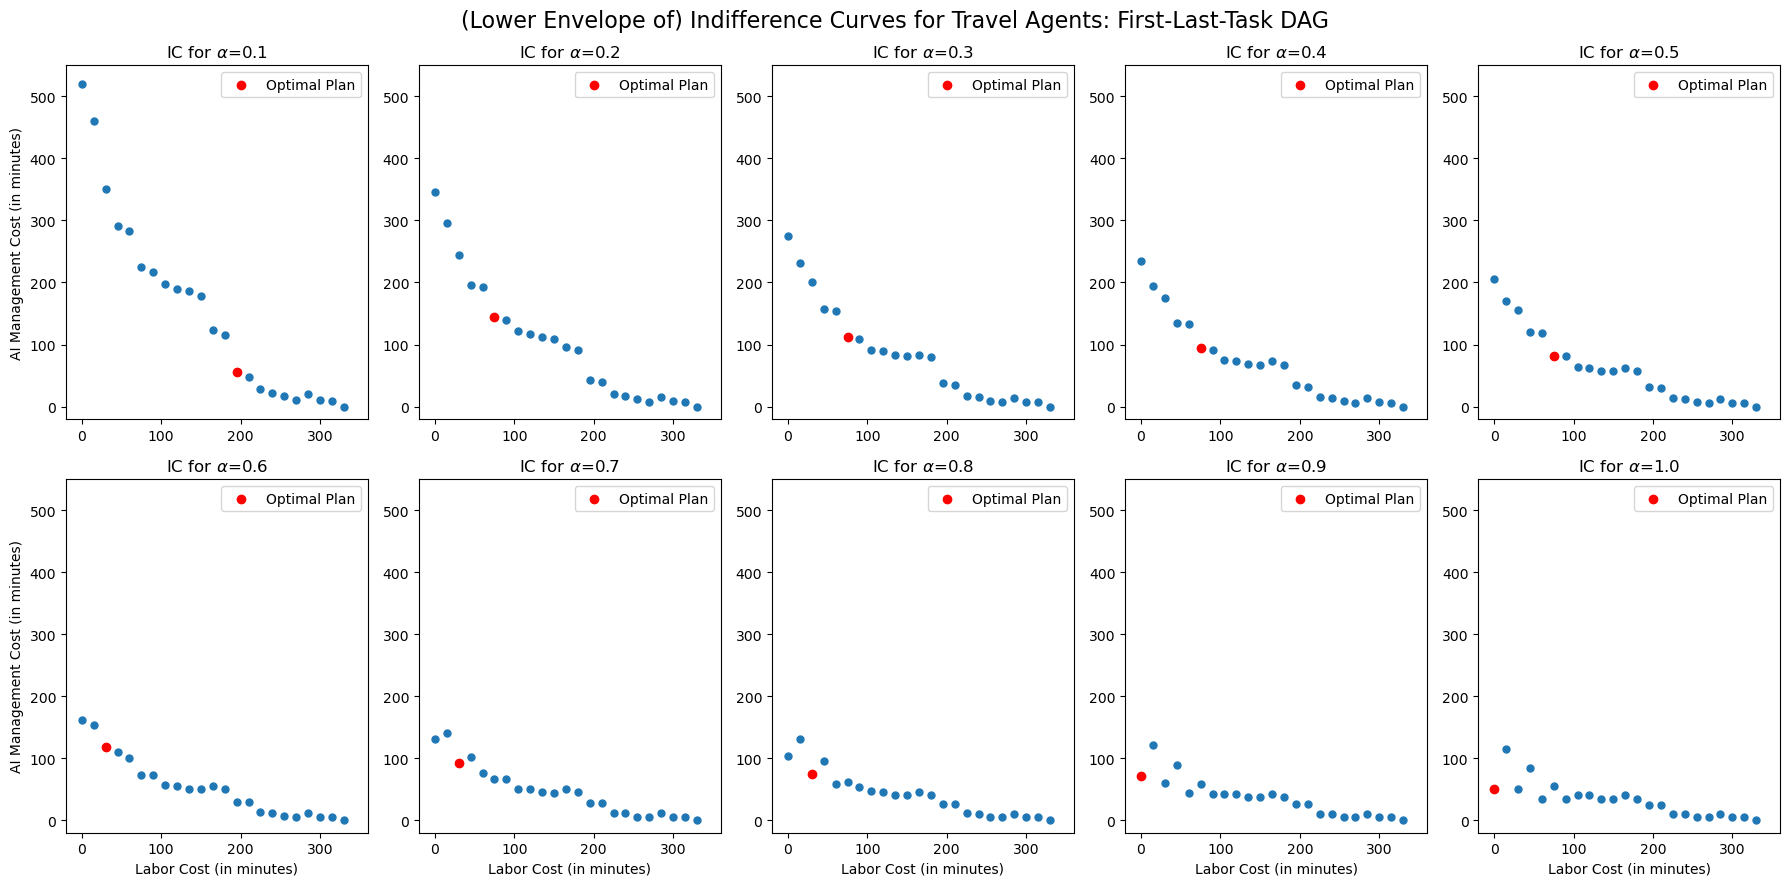

In [426]:
#alpha_list = execution_plan_costs_df['alpha'].unique().tolist()

# Create a 2x5 grid of subplots
fig, axs = plt.subplots(2, 5, figsize=(18, 9))

# Iterate over each subplot position and add a plot
for i in range(2): 
    for j in range(5): 
        alpha_index = (i % 5) * 5 + j
        my_alpha = alpha_list[alpha_index+1] # ignore epsilon

        # subset corresponding alpha's data from master dataset
        my_alpha_execution_plan_costs_df = execution_plan_costs_df[execution_plan_costs_df['alpha']==my_alpha]
        #print(len(my_alpha_execution_plan_costs_df))
        unique_pair_count = my_alpha_execution_plan_costs_df.drop_duplicates(subset=['labor_cost', 'management_cost']).shape[0]
        print(unique_pair_count)


        # Group by column A and get the index of the minimum value in column B
        idx = my_alpha_execution_plan_costs_df.groupby('labor_cost')['management_cost'].idxmin()

        # Filter the DataFrame to keep only the rows with the minimum value in column B for each value in A
        lower_envelope_df = my_alpha_execution_plan_costs_df.loc[idx]
        

        axs[i, j].scatter(lower_envelope_df.labor_cost, lower_envelope_df.management_cost, s=25)
        axs[i, j].scatter(lower_envelope_df[lower_envelope_df['min_total_cost_flag']==True].labor_cost, 
                lower_envelope_df[lower_envelope_df['min_total_cost_flag']==True].management_cost,
                color='red',
                label = 'Optimal Plan')
        
        axs[i, j].title.set_text(r'IC for $\alpha$' + f'={np.round(my_alpha,1)}')
        if i == 1:
              axs[i, j].set_xlabel('Labor Cost (in minutes)')
        if j == 0:
              axs[i, j].set_ylabel('AI Management Cost (in minutes)')
        axs[i, j].legend(loc = 'upper right')

        axs[i, j].set_xlim(-20, 360)
        axs[i, j].set_ylim(-20, 550)


fig.suptitle(f'(Lower Envelope of) Indifference Curves for {plot_title_occupation}: First-Last-Task DAG', fontsize=16)

# Save the plot
plt.savefig(f'{occupation_folder}/indiffCurves/{occupation}_indiffCurves_FLT.png', dpi=300)
#plt.savefig(f'{data_path}/daily_tasks_occupations_analysis/plots/indiffCurves/{occupation}_indiffCurves_FLT.png', dpi=300)

plt.tight_layout()

# Show plot
plt.show()



In [427]:
my_alpha_execution_plan_costs_df

,alpha,execution_plan,human_tasks,total_cost,labor_cost,management_cost,min_total_cost_flag
115430,1.0,"[[0, 1, 2, 3, 4, 5, 6, 7]]",[],50.000002,0,50.000002,True
115431,1.0,"[[0, 3, 4, 6], [1, 2, 5, 7]]",[],150.000002,0,150.000002,False
115432,1.0,"[[0, 1, 2, 3, 5, 6], [4, 7]]",[],150.000003,0,150.000003,False
115433,1.0,"[[0, 1, 2, 4, 5, 6], [3, 7]]",[],150.000003,0,150.000003,False
115434,1.0,"[[0, 1, 2, 4, 5, 6, 7], [3]]",[],145.000003,0,145.000003,False
...,...,...,...,...,...,...,...
126968,1.0,"[[0], [1], [2], [3], [4], [5], [6], [7]]","[0, 1, 2, 4, 5, 6, 7]",330.000000,300,30.000000,False
126969,1.0,"[[0], [1], [2], [3], [4], [5], [6], [7]]","[0, 1, 3, 4, 5, 6, 7]",305.000000,300,5.000000,False
126970,1.0,"[[0], [1], [2], [3], [4], [5], [6], [7]]","[0, 2, 3, 4, 5, 6, 7]",330.000000,300,30.000000,False
126971,1.0,"[[0], [1], [2], [3], [4], [5], [6], [7]]","[1, 2, 3, 4, 5, 6, 7]",345.000000,315,30.000000,False


In [428]:
# alpha = alpha_list[0]

# my_alpha_execution_plan_costs_df = execution_plan_costs_df[execution_plan_costs_df['alpha']==alpha]

# fig, ax = plt.subplots()
# ax.scatter(my_alpha_execution_plan_costs_df.labor_cost, my_alpha_execution_plan_costs_df.management_cost)
# ax.scatter(my_alpha_execution_plan_costs_df[my_alpha_execution_plan_costs_df['min_total_cost_flag']==True].labor_cost, 
#            my_alpha_execution_plan_costs_df[my_alpha_execution_plan_costs_df['min_total_cost_flag']==True].management_cost,
#            color='red',
#            label = 'Execution Plan w/ Minimum Cost')

# ax.title.set_text(r'Indifference Curve for $\alpha$s' + f'={np.round(alpha,1)}')
# ax.set_xlabel('Labor Cost (in minutes)')
# ax.set_ylabel('AI Management Cost (in minutes)')
# ax.legend(loc = 'upper right')

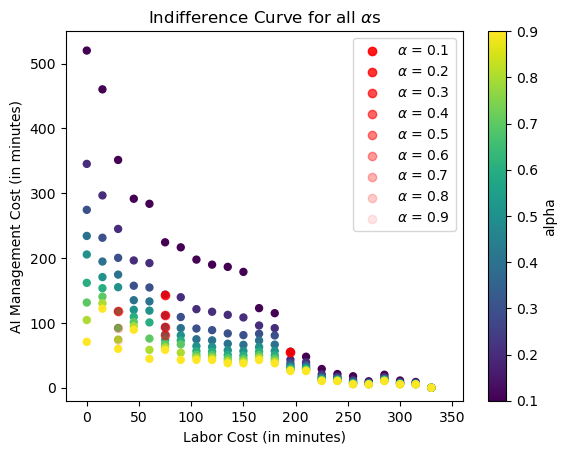

In [451]:
# alpha_list = execution_plan_costs_df['alpha'].unique().tolist()
# alpha = alpha_list[0]

# my_alpha_execution_plan_costs_df = execution_plan_costs_df[execution_plan_costs_df['alpha']==alpha]
execution_plan_costs_df = execution_plan_costs_df[(execution_plan_costs_df.alpha > epsilon) & (execution_plan_costs_df.alpha < 1-epsilon)]


# Group by column A and get the index of the minimum value in column B
idx = execution_plan_costs_df.groupby(['alpha', 'labor_cost'])['management_cost'].idxmin()

# Filter the DataFrame to keep only the rows with the minimum value in column B for each value in A
lower_envelope_df = execution_plan_costs_df.loc[idx]


fig, ax = plt.subplots()
scatter1 = ax.scatter(lower_envelope_df.labor_cost, lower_envelope_df.management_cost, c=lower_envelope_df['alpha'], cmap='viridis', s=25)
ax.scatter(lower_envelope_df[(lower_envelope_df.min_total_cost_flag==True) & (lower_envelope_df.alpha==alpha_list[1])].labor_cost, 
           lower_envelope_df[(lower_envelope_df.min_total_cost_flag==True) & (lower_envelope_df.alpha==alpha_list[1])].management_cost,
           color='red',
           label = r'$\alpha$ = 0.1',
           alpha = 0.9)
ax.scatter(lower_envelope_df[(lower_envelope_df.min_total_cost_flag==True) & (lower_envelope_df.alpha==alpha_list[2])].labor_cost, 
           lower_envelope_df[(lower_envelope_df.min_total_cost_flag==True) & (lower_envelope_df.alpha==alpha_list[2])].management_cost,
           color='red',
           label = r'$\alpha$ = 0.2',
           alpha = 0.8)
ax.scatter(lower_envelope_df[(lower_envelope_df.min_total_cost_flag==True) & (lower_envelope_df.alpha==alpha_list[3])].labor_cost, 
           lower_envelope_df[(lower_envelope_df.min_total_cost_flag==True) & (lower_envelope_df.alpha==alpha_list[3])].management_cost,
           color='red',
           label = r'$\alpha$ = 0.3',
           alpha = 0.7)
ax.scatter(lower_envelope_df[(lower_envelope_df.min_total_cost_flag==True) & (lower_envelope_df.alpha==alpha_list[4])].labor_cost, 
           lower_envelope_df[(lower_envelope_df.min_total_cost_flag==True) & (lower_envelope_df.alpha==alpha_list[4])].management_cost,
           color='red',
           label = r'$\alpha$ = 0.4',
           alpha = 0.6)
ax.scatter(lower_envelope_df[(lower_envelope_df.min_total_cost_flag==True) & (lower_envelope_df.alpha==alpha_list[5])].labor_cost, 
           lower_envelope_df[(lower_envelope_df.min_total_cost_flag==True) & (lower_envelope_df.alpha==alpha_list[5])].management_cost,
           color='red',
           label = r'$\alpha$ = 0.5',
           alpha = 0.5)
ax.scatter(lower_envelope_df[(lower_envelope_df.min_total_cost_flag==True) & (lower_envelope_df.alpha==alpha_list[6])].labor_cost, 
           lower_envelope_df[(lower_envelope_df.min_total_cost_flag==True) & (lower_envelope_df.alpha==alpha_list[6])].management_cost,
           color='red',
           label = r'$\alpha$ = 0.6',
           alpha = 0.4)
ax.scatter(lower_envelope_df[(lower_envelope_df.min_total_cost_flag==True) & (lower_envelope_df.alpha==alpha_list[6])].labor_cost, 
           lower_envelope_df[(lower_envelope_df.min_total_cost_flag==True) & (lower_envelope_df.alpha==alpha_list[6])].management_cost,
           color='red',
           label = r'$\alpha$ = 0.7',
           alpha = 0.3)
ax.scatter(lower_envelope_df[(lower_envelope_df.min_total_cost_flag==True) & (lower_envelope_df.alpha==alpha_list[7])].labor_cost, 
           lower_envelope_df[(lower_envelope_df.min_total_cost_flag==True) & (lower_envelope_df.alpha==alpha_list[7])].management_cost,
           color='red',
           label = r'$\alpha$ = 0.8',
           alpha = 0.2)
ax.scatter(lower_envelope_df[(lower_envelope_df.min_total_cost_flag==True) & (lower_envelope_df.alpha==alpha_list[8])].labor_cost, 
           lower_envelope_df[(lower_envelope_df.min_total_cost_flag==True) & (lower_envelope_df.alpha==alpha_list[8])].management_cost,
           color='red',
           label = r'$\alpha$ = 0.9',
           alpha = 0.1)



fig.colorbar(scatter1, ax=ax, label='alpha')
ax.title.set_text(r'Indifference Curve for all $\alpha$s')
ax.set_xlabel('Labor Cost (in minutes)')
ax.set_ylabel('AI Management Cost (in minutes)')
ax.legend(loc = 'upper right')

ax.set_xlim(-20, 360)
ax.set_ylim(-20, 550)

plt.savefig(f'{occupation_folder}/indiffCurves/{occupation}_indiffCurves_FLT_combined.png', dpi=300)

In [447]:
lower_envelope_df[(lower_envelope_df.min_total_cost_flag==True) & (lower_envelope_df.alpha==alpha_list[1])]

,alpha,execution_plan,human_tasks,total_cost,labor_cost,management_cost,min_total_cost_flag
22747,0.1,"[[0], [1], [2], [3], [4], [5], [6, 7]]","[0, 1, 3, 4]",250.608466,195,55.608466,True
